# Bring in packages that are needed

In [1]:
import sys
#sys.path
#sys.executable

import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
import numpy as np
import pandas as pd
from nd2reader import ND2Reader 
from scipy import ndimage as ndi
import pims
from PIL import Image

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

from ipywidgets import interact
import ipywidgets as ipw
# mpl.rcParams['figure.figsize'] = [15.0, 10.0]



# Take a look at the current image
This is an important step during initial development of the code and in subsequent use of the code, because it's a sanity check that the data going into the analysis algorithm are acceptable.

### Load images to be used for testing image analysis

In [3]:
imageDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/20180927/'
expID = 'SSN_089_001'

In [4]:
def loadImages(imageDir,expID):
    images = pims.open(imageDir+expID+'.nd2')
    images.bundle_axes = ['z', 'y', 'x']
#     meta = images.metadata
#     print(meta)
#     numSlices = meta['total_images_per_channel']
    
    imageArray = np.asarray(images)
    imageArray = imageArray.squeeze()
    # print(imageArray.shape)
    return imageArray

def getMetadata(imageDir,experimentID):
    ## need to think about if I want to just return all the metadata in a dataframe for later slicing and dicing
    
    
    # Access google drive spreadsheet
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('SenseOfTouchResearch-e5927f56c4d0.json', scope)
    c = gspread.authorize(credentials)
    metadataSpread = c.open_by_key('1LsTdPBOW79XSkk5DJv2ckiVTvpofAOOd_dJL4cgtxBQ')
    metadataFrame = pd.DataFrame(metadataSpread.sheet1.get_all_records())
    gdriveMetadata = metadataFrame.loc[metadataFrame['Experiment ID'] == 'SSN_089_001']
    
    # Access the metadata embedded in the file from the microscope
    images = pims.open(imageDir+expID+'.nd2')
    meta = images.metadata
    keysToKeep = ['height','width','date','total_images_per_channel','channels','pixel_microns']
    metadataFromScope = { keyToKeep: meta[keyToKeep] for keyToKeep in keysToKeep }
    metadataFromScope = pd.DataFrame(metadataFromScope)
    
    gdriveMetadata=gdriveMetadata.reset_index(drop=True)
    metadataFromScope=metadataFromScope.reset_index(drop=True)
    currentMetadata = metadataFromScope.join(gdriveMetadata)

    return currentMetadata
    
    
    
imageArray = loadImages(imageDir,expID)
thisMetadata = getMetadata(imageDir,expID)


Probably a good idea to display any notes from the metadata forms since that's where any problems with a given trial would be documented.

In [5]:
thisMetadata


,height,width,date,total_images_per_channel,channels,pixel_microns,Bleach Date,Bleach Time,Cultivation Temperature (°C),Device ID,...,Microscope,Neuron,Notes,Number of eggs visible,Objective,Purpose of Experiment,Timestamp,Worm Strain,Worm head orientation,Worm vulva orientation
0,512,200,2018-09-27 13:59:02,235,SDC 561-ALN,0.354202,9/24/2018,3:15:00 PM,20,Y5P18-7,...,CSIF Spinning Disk,PVM,"Some autofluorescence, but can see TRNs.",0,40x oil,Baseline measurement,9/27/2018 14:00:11,NM3573,Headfirst,West


### Display max projection to get an idea of what we're working with

Worm vulva is on the West side.


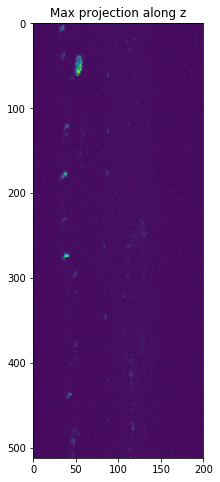

In [6]:
def dispMaxProjection(images):
    # convert data to numpy array
    maxProjection = np.amax(images,0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    
    # print a bit of info for the user
    vulvaSide = thisMetadata.loc[0,'Worm vulva orientation']
    print('Worm vulva is on the '+vulvaSide+ ' side.')
    
    # figure axis setup  with increased figure size
    maxProjFig = plt.figure(figsize = (8,8)) 
    ax = maxProjFig.add_subplot(111)

    # display  image 
    ax.imshow(maxProjection, interpolation='none')
    ax.set_title('Max projection along z')
#     plt.show()

    return maxProjFig
    
testFig = dispMaxProjection(imageArray) 
testFig.show()

### Create scrollable fig to find slices of interest

In [7]:
def plotCurrentSlice(currentSlice,stack):
    # figure axis setup  with increased figure size
    imFig, ax = plt.subplots(figsize=(8,8))

    # display initial image 
    thisIm = ax.imshow(stack[currentSlice], interpolation='none')
    
    return 
def scrollingFig(currentStack):
    interact(plotCurrentSlice,currentSlice = ipw.IntSlider(min=0,max=currentStack.shape[0]-1,step=1,value=0),stack = ipw.fixed(currentStack))

In [9]:
scrollingFig(imageArray)

interactive(children=(IntSlider(value=0, description='currentSlice', max=234), Output()), _dom_classes=('widge…

# Preprocessing 

### Choose which slices to analyze

In [10]:
# Manual choice
slicesToAnalyze = imageArray[50:90]

Manually choosing slices is probably not sustainable.

In [11]:
# Automated choice

### Preprocessing - Filter image to remove noise

In [12]:
# Gaussian filter
gaussFiltSubStack = ndi.filters.gaussian_filter(slicesToAnalyze,2)
scrollingFig(gaussFiltSubStack)

interactive(children=(IntSlider(value=0, description='currentSlice', max=39), Output()), _dom_classes=('widget…

In [13]:
# Median filter
medianFiltSubStack = ndi.filters.median_filter(slicesToAnalyze,3)
scrollingFig(medianFiltSubStack)

interactive(children=(IntSlider(value=0, description='currentSlice', max=39), Output()), _dom_classes=('widget…

The median filter doesn't blur the mitochondria as much, but the contrast doesn't look as high.

In [ ]:
# Background subtraction

# Segmentation

In [14]:
gaussFiltSubStack.shape

(40, 512, 200)

Frame([[[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       ...,


       [[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        
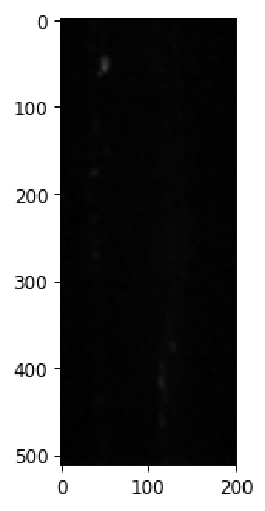
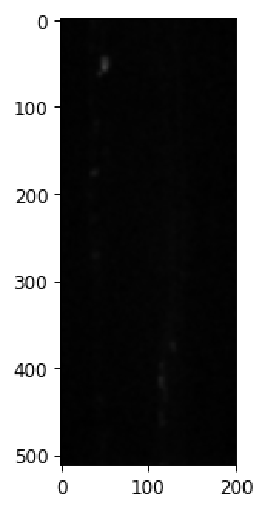
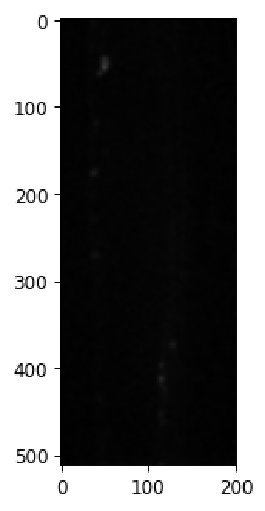
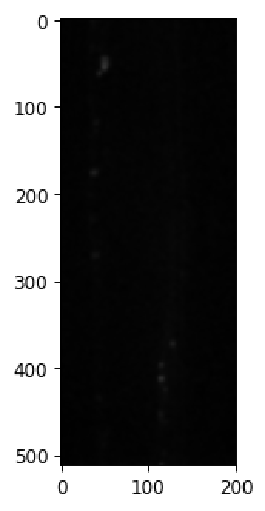
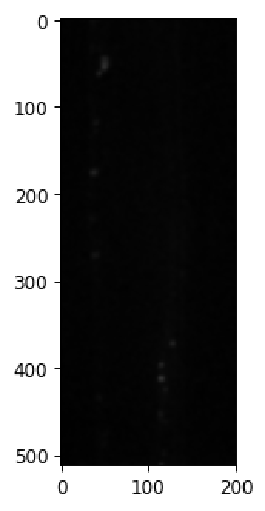
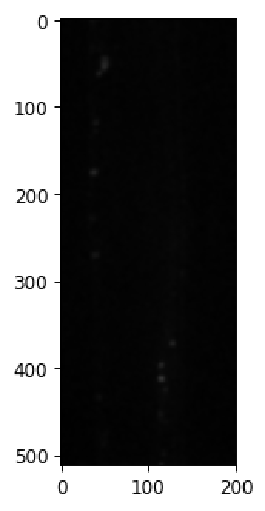
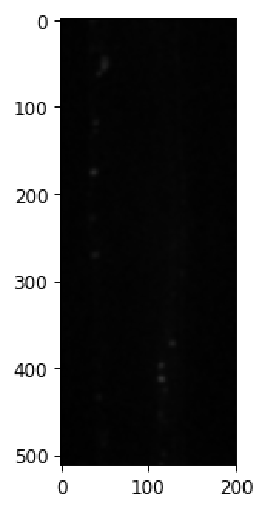
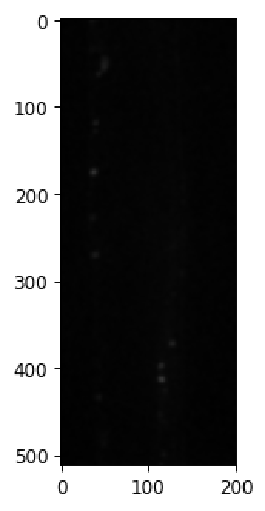
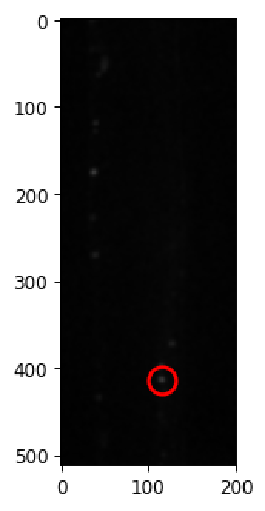
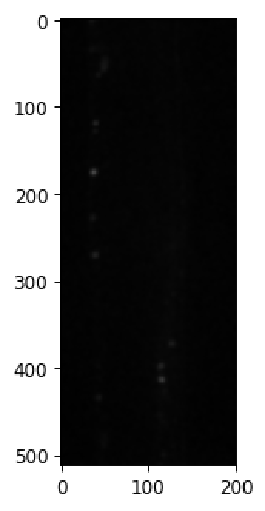
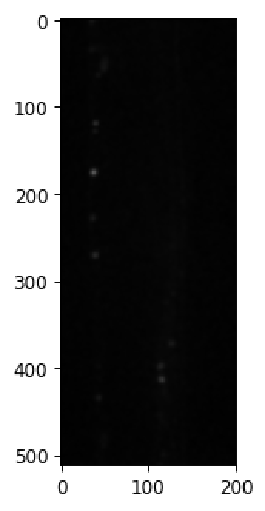
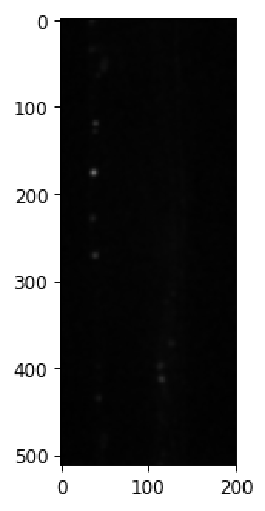
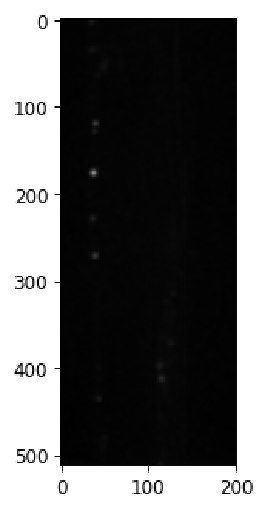
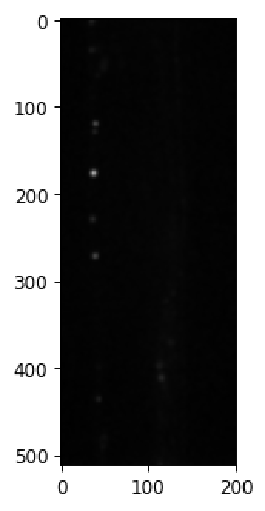
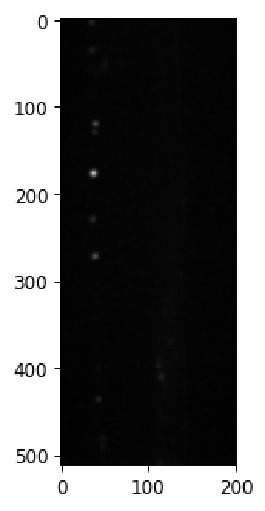
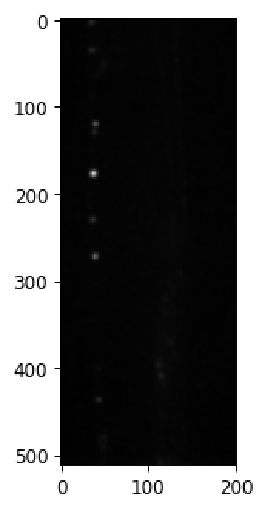
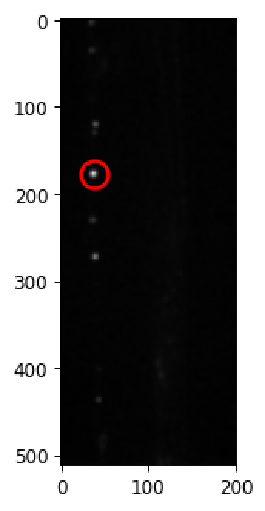
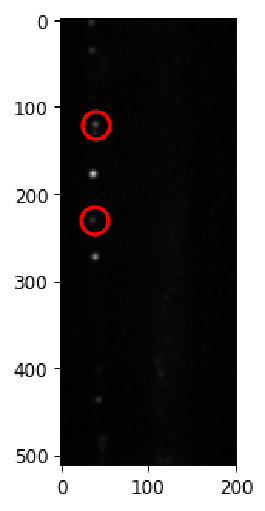
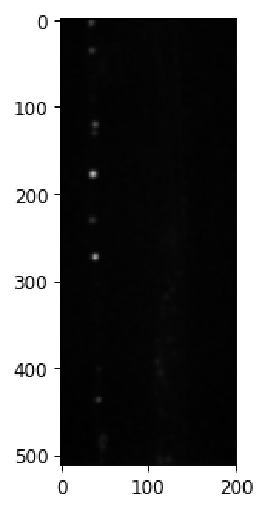
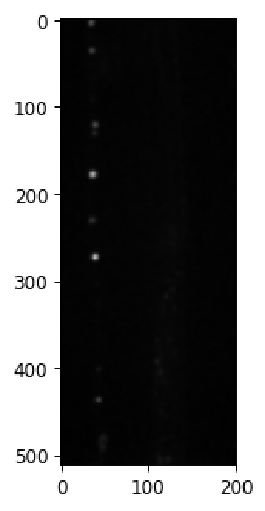
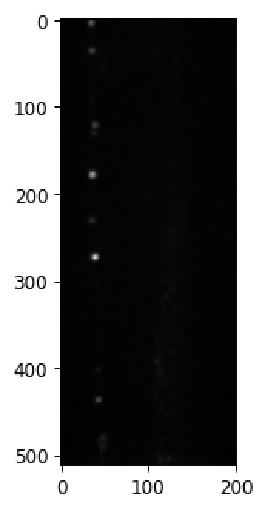
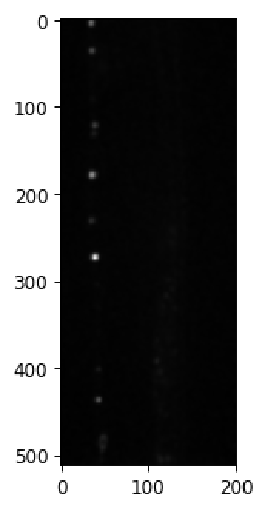
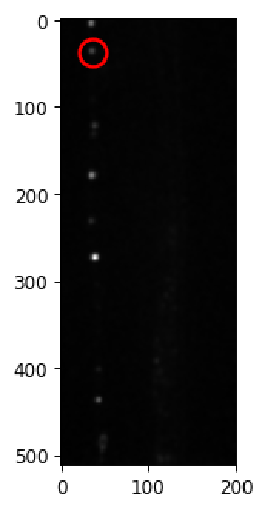
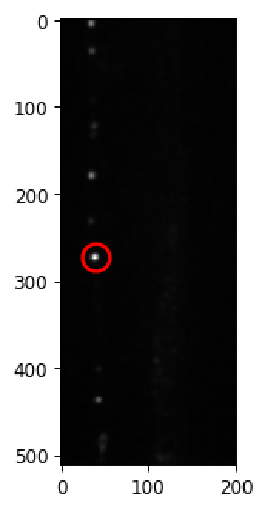
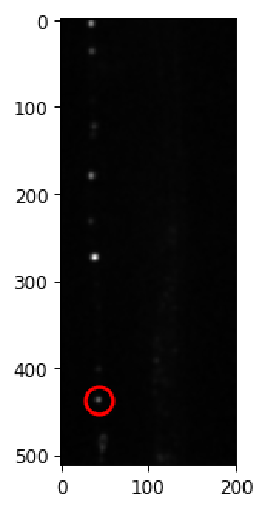
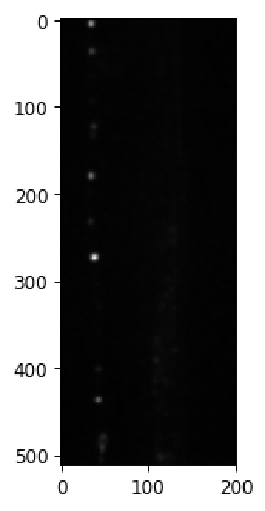
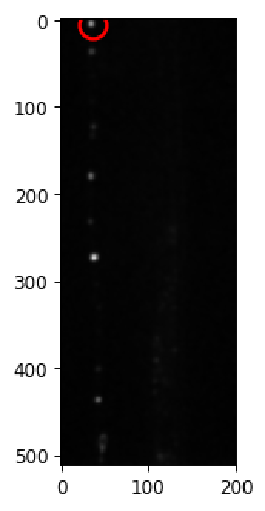
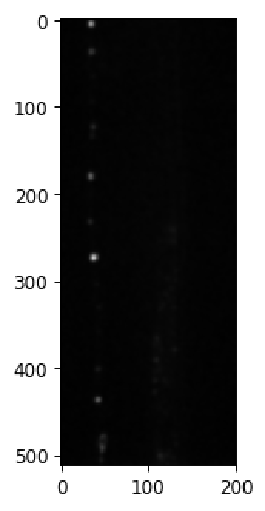
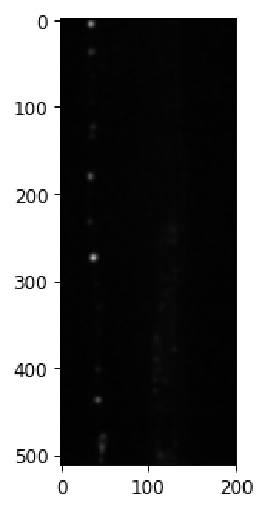
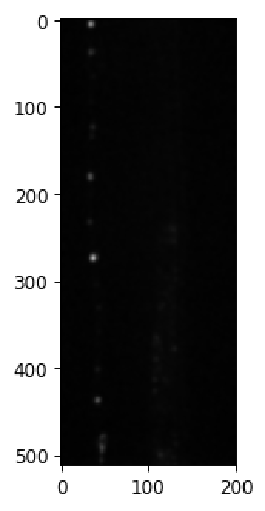
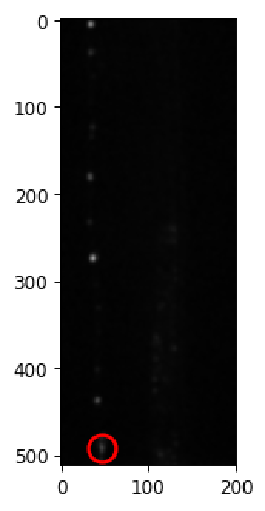
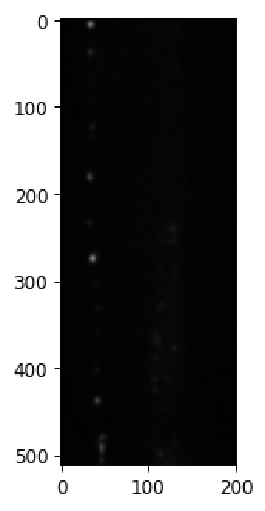
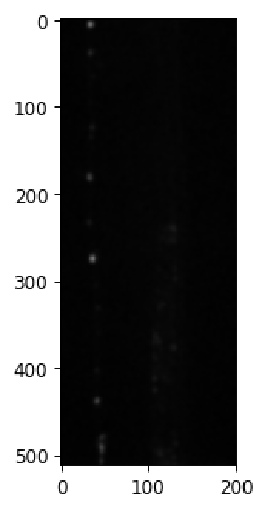
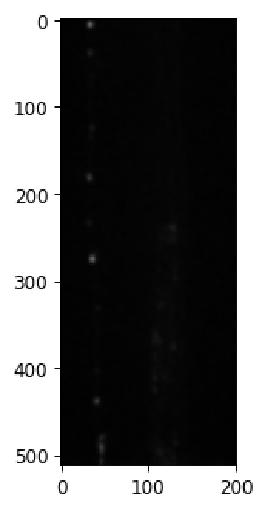
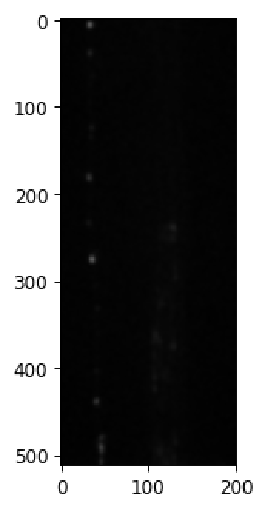
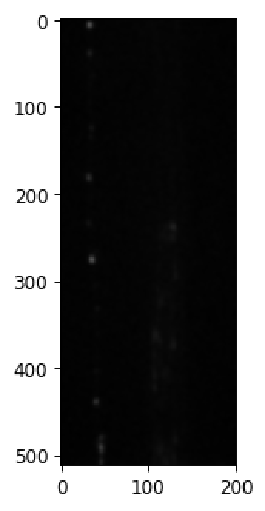
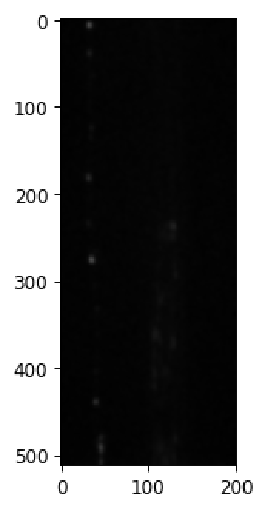
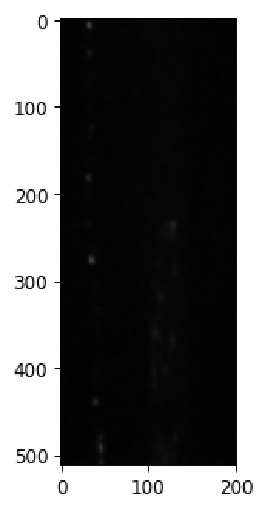
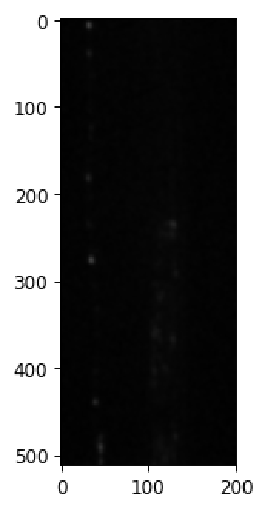
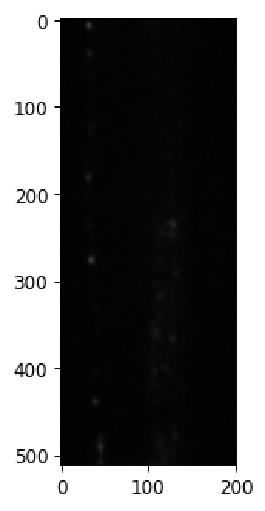

In [15]:
# 3D particle tracking (trackpy)
# tutorial here: http://soft-matter.github.io/trackpy/v0.4.1/tutorial/tracking-3d.html
import trackpy as tp
warnings.filterwarnings("ignore", message="Using a non-tuple sequence for multidimensional indexing is deprecated")

mitoCandidates = tp.locate(gaussFiltSubStack,diameter=(15,9,9),percentile=99) # does this perform gaussian blurring?
tp.annotate3d(mitoCandidates,gaussFiltSubStack)


Tried several different percentile settings for trackpy locate function. Even a percentile of 80 results in a lot of off-target points. High 90s seem to be the best setting. Not sure how to optimize this.

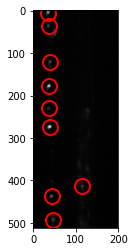

In [16]:
maxProjection = np.amax(gaussFiltSubStack,0) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)

tp.annotate(mitoCandidates,maxProjection)

Worm vulva is on the West side.


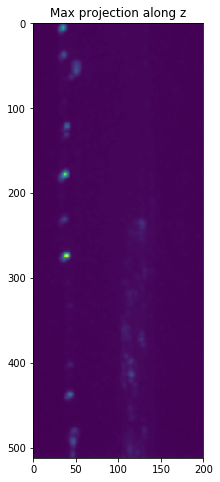

In [17]:
myFig = dispMaxProjection(gaussFiltSubStack)

In [18]:
# Watershed algorithm

# Postprocessing

### Remove objects that are the wrong size (these aren't the mitochondria we're looking for)

### Find centroids of remaining objects

# Tracking

# Calculate Strain

# Plot results